#**DEEPFAKE IMAGE DETECTION**

###### Project by Ruchi Kolte, Anjali Mohanthy, Neha Shaik

#**Installing all the Libraries**

In [ ]:
!pip install opendatasets
!pip install pandas
!pip install kaggle
!pip install vit-keras
!pip install tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 4.3 MB/s eta 0:00:00


In [ ]:
import opendatasets as od
import pandas
import os
import shutil
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
from keras.models import Model
from keras.layers import Dense, Dropout
from keras.models import Sequential
from vit_keras import vit
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


#**Loading the dataset**

In [ ]:
od.download(
	"https://www.kaggle.com/datasets/manjilkarki/deepfake-and-real-images/data")

#if u wanna try some other dataset change the link


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: anjalibalaram2501
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/manjilkarki/deepfake-and-real-images


100%|██████████| 1.68G/1.68G [00:06<00:00, 268MB/s]


# **Data Preprocessing**

In [ ]:
#defining paths to training, testing and validation data directory respectively

base_path = '/content/deepfake-and-real-images/Dataset'

train_directory = os.path.join(base_path, 'Train')

validation_directory = os.path.join(base_path, 'Validation')

test_directory = os.path.join(base_path, 'Test')

In [ ]:
#defining image dimensions and batch size

image_height = 224
image_width = 224
batch_size = 40

In [ ]:
# using image data generator for data preprocessing of the training data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    brightness_range=[0.5, 1.5]
)

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
validation_datagen = ImageDataGenerator(rescale=1./255)


In [ ]:

train_generator = train_datagen.flow_from_directory(
    train_directory,
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle = True ,
)
test_generator = test_datagen.flow_from_directory(
    test_directory,
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle = False
)


validation_generator = validation_datagen.flow_from_directory(
    validation_directory,
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)



Found 140002 images belonging to 2 classes.
Found 10905 images belonging to 2 classes.
Found 39428 images belonging to 2 classes.


# **Feature Extraction with VGG16**

In [ ]:
base_model_vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(image_height, image_width, 3))
for layer in base_model_vgg16.layers:
    layer.trainable = False
model_vgg16 = Model(inputs=base_model_vgg16.input, outputs=base_model_vgg16.output)

train_features_vgg16 = model_vgg16.predict(train_generator, steps=train_generator.samples/train_generator.batch_size, verbose=1)
validation_features_vgg16 = model_vgg16.predict(validation_generator, steps=validation_generator.samples/validation_generator.batch_size, verbose=1)
test_features_vgg16 = model_vgg16.predict(test_generator, steps=test_generator.samples/test_generator.batch_size, verbose=1)

train_features_flat_vgg16 = np.reshape(train_features_vgg16, (train_features_vgg16.shape[0], -1))
validation_features_flat_vgg16 = np.reshape(validation_features_vgg16, (validation_features_vgg16.shape[0], -1))
test_features_flat_vgg16 = np.reshape(test_features_vgg16, (test_features_vgg16.shape[0], -1))

train_labels = train_generator.classes
validation_labels = validation_generator.classes
test_labels = test_generator.classes

272/272 [==============================] - 189s 693ms/step


# **Feature Extraction with ResNet50**

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
import numpy as np

# Define image dimensions; adjust as needed.
image_height = 224
image_width = 224

# Initialize the ResNet50 base model.
# Ensure include_top is False if you want to add custom layers.
base_model_resnet50 = ResNet50(weights='imagenet', include_top=False, input_shape=(image_height, image_width, 3))

# Define the new output processing.
x = base_model_resnet50.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(1, activation='sigmoid')(x)  # For binary classification.

# Create the complete model.
model_resnet50 = Model(inputs=base_model_resnet50.input, outputs=predictions)

# Compile the model with RMSprop optimizer.
model_resnet50.compile(optimizer=RMSprop(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Assuming 'train_generator', 'validation_generator', and 'test_generator' are properly defined elsewhere.
train_features_resnet50 = model_resnet50.predict(train_generator, steps=train_generator.samples/train_generator.batch_size, verbose=1)
validation_features_resnet50 = model_resnet50.predict(validation_generator, steps=validation_generator.samples/validation_generator.batch_size, verbose=1)
test_features_resnet50 = model_resnet50.predict(test_generator, steps=test_generator.samples/test_generator.batch_size, verbose=1)

# Reshape the outputs if needed for further analysis or different model inputs.
train_features_flat_resnet50 = np.reshape(train_features_resnet50, (train_features_resnet50.shape[0], -1))
validation_features_flat_resnet50 = np.reshape(validation_features_resnet50, (validation_features_resnet50.shape[0], -1))
test_features_flat_resnet50 = np.reshape(test_features_resnet50, (test_features_resnet50.shape[0], -1))


272/272 [==============================] - 178s 654ms/step


# **Feature Extraction with VIT**

In [ ]:
model_vit = vit.vit_b32(
    image_size=224,
    activation='sigmoid',
    pretrained=True,
    include_top=False,
    pretrained_top=False,
    classes=1
)

train_features_vit = model_vit.predict(train_generator, steps=train_generator.samples//batch_size, verbose=1)
validation_features_vit = model_vit.predict(validation_generator, steps=validation_generator.samples//batch_size, verbose=1)
test_features_vit = model_vit.predict(test_generator, steps=test_generator.samples//batch_size, verbose=1)

train_features_flat_vit = np.reshape(train_features_vit, (train_features_vit.shape[0], -1))
validation_features_flat_vit = np.reshape(validation_features_vit, (validation_features_vit.shape[0], -1))
test_features_flat_vit = np.reshape(test_features_vit, (test_features_vit.shape[0], -1))

272/272 [==============================] - 188s 690ms/step


# **Model Training with VGG16**

In [ ]:
from keras.layers import Dense, Dropout, BatchNormalization, Activation
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

model_top_vgg16 = Sequential()
model_top_vgg16.add(Dense(1024, input_dim=train_features_flat_vgg16.shape[1]))
model_top_vgg16.add(BatchNormalization())
model_top_vgg16.add(Activation('relu'))
model_top_vgg16.add(Dropout(0.5))
model_top_vgg16.add(Dense(512))
model_top_vgg16.add(BatchNormalization())
model_top_vgg16.add(Activation('relu'))
model_top_vgg16.add(Dropout(0.3))
model_top_vgg16.add(Dense(1, activation='sigmoid'))

model_top_vgg16.compile(optimizer=RMSprop(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, min_lr=1e-6)
checkpoint = ModelCheckpoint('vgg16_model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)

history_vgg16 = model_top_vgg16.fit(train_features_flat_vgg16, train_labels, epochs=50, batch_size=batch_size,
                                    validation_data=(validation_features_flat_vgg16, validation_labels),
                                    callbacks=[early_stopping, lr_reducer, checkpoint])


Epoch 1/50
---------------
Training - loss: 0.2695 - accuracy: 0.8995
Validation - loss: 0.4795 - accuracy: 0.7476

Epoch 2/50
---------------
Training - loss: 0.1819 - accuracy: 0.7780
Validation - loss: 0.4733 - accuracy: 0.8852

Epoch 3/50
---------------
Training - loss: 0.2070 - accuracy: 0.7761
Validation - loss: 0.3723 - accuracy: 0.8091

Epoch 4/50
---------------
Training - loss: 0.2438 - accuracy: 0.8816
Validation - loss: 0.2474 - accuracy: 0.7795

Epoch 5/50
---------------
Training - loss: 0.2642 - accuracy: 0.7364
Validation - loss: 0.1068 - accuracy: 0.7231

Epoch 6/50
---------------
Training - loss: 0.4203 - accuracy: 0.8968
Validation - loss: 0.3611 - accuracy: 0.8365

Epoch 7/50
---------------
Training - loss: 0.1130 - accuracy: 0.7630
Validation - loss: 0.2836 - accuracy: 0.7150

Epoch 8/50
---------------
Training - loss: 0.2425 - accuracy: 0.8300
Validation - loss: 0.1603 - accuracy: 0.7893

Epoch 9/50
---------------
Training - loss: 0.1597 - accuracy: 0.7841
Va

# **Model Training with ResNet50**

In [ ]:
model_top_resnet50 = Sequential()
model_top_resnet50.add(Dense(1024, input_dim=train_features_flat_resnet50.shape[1]))
model_top_resnet50.add(BatchNormalization())
model_top_resnet50.add(Activation('relu'))
model_top_resnet50.add(Dropout(0.5))
model_top_resnet50.add(Dense(512))
model_top_resnet50.add(BatchNormalization())
model_top_resnet50.add(Activation('relu'))
model_top_resnet50.add(Dropout(0.3))
model_top_resnet50.add(Dense(1, activation='sigmoid'))

model_top_resnet50.compile(optimizer=RMSprop(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

early_stopping_resnet50 = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_reducer_resnet50 = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, min_lr=1e-6)
checkpoint_resnet50 = ModelCheckpoint('resnet50_model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)

history_resnet50 = model_top_resnet50.fit(train_features_flat_resnet50, train_labels, epochs=50, batch_size=batch_size,
                                          validation_data=(validation_features_flat_resnet50, validation_labels),
                                          callbacks=[early_stopping_resnet50, lr_reducer_resnet50, checkpoint_resnet50])

Epoch 1/50
---------------
Training - loss: 0.3654 - accuracy: 0.8435
Validation - loss: 0.1968 - accuracy: 0.8334

Epoch 2/50
---------------
Training - loss: 0.3447 - accuracy: 0.8356
Validation - loss: 0.1631 - accuracy: 0.8263

Epoch 3/50
---------------
Training - loss: 0.3474 - accuracy: 0.8989
Validation - loss: 0.4423 - accuracy: 0.8386

Epoch 4/50
---------------
Training - loss: 0.3333 - accuracy: 0.7709
Validation - loss: 0.3268 - accuracy: 0.8756

Epoch 5/50
---------------
Training - loss: 0.4738 - accuracy: 0.8152
Validation - loss: 0.4983 - accuracy: 0.8632

Epoch 6/50
---------------
Training - loss: 0.1294 - accuracy: 0.7673
Validation - loss: 0.2019 - accuracy: 0.7416

Epoch 7/50
---------------
Training - loss: 0.4344 - accuracy: 0.7692
Validation - loss: 0.2604 - accuracy: 0.7589

Epoch 8/50
---------------
Training - loss: 0.1796 - accuracy: 0.7006
Validation - loss: 0.4937 - accuracy: 0.8183

Epoch 9/50
---------------
Training - loss: 0.2997 - accuracy: 0.7507
Va

# **Model Training with VIT**

In [ ]:
model_top_vit = Sequential()
model_top_vit.add(Dense(1024, input_dim=train_features_flat_vit.shape[1]))
model_top_vit.add(BatchNormalization())
model_top_vit.add(Activation('relu'))
model_top_vit.add(Dropout(0.5))
model_top_vit.add(Dense(512))
model_top_vit.add(BatchNormalization())
model_top_vit.add(Activation('relu'))
model_top_vit.add(Dropout(0.3))
model_top_vit.add(Dense(1, activation='sigmoid'))

model_top_vit.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

early_stopping_vit = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_reducer_vit = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, min_lr=1e-6)
checkpoint_vit = ModelCheckpoint('vit_model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)

history_vit = model_top_vit.fit(train_features_flat_vit, train_labels, epochs=50, batch_size=batch_size,
                                validation_data=(validation_features_flat_vit, validation_labels),
                                callbacks=[early_stopping_vit, lr_reducer_vit, checkpoint_vit])

Epoch 1/50
---------------
Training - loss: 0.4337 - accuracy: 0.7807
Validation - loss: 0.1176 - accuracy: 0.7655

Epoch 2/50
---------------
Training - loss: 0.4950 - accuracy: 0.7017
Validation - loss: 0.2228 - accuracy: 0.7560

Epoch 3/50
---------------
Training - loss: 0.1404 - accuracy: 0.7518
Validation - loss: 0.3051 - accuracy: 0.8149

Epoch 4/50
---------------
Training - loss: 0.1427 - accuracy: 0.8826
Validation - loss: 0.4926 - accuracy: 0.7704

Epoch 5/50
---------------
Training - loss: 0.2426 - accuracy: 0.8177
Validation - loss: 0.4417 - accuracy: 0.8723

Epoch 6/50
---------------
Training - loss: 0.4869 - accuracy: 0.8389
Validation - loss: 0.4025 - accuracy: 0.8425

Epoch 7/50
---------------
Training - loss: 0.3725 - accuracy: 0.8641
Validation - loss: 0.3611 - accuracy: 0.7422

Epoch 8/50
---------------
Training - loss: 0.2696 - accuracy: 0.7423
Validation - loss: 0.2580 - accuracy: 0.8119

Epoch 9/50
---------------
Training - loss: 0.1708 - accuracy: 0.8382
Va

# **Model Evaluation with VGG16**

In [ ]:
vgg16_predictions = model_top_vgg16.predict(test_features_flat_vgg16)
vgg16_predictions = [1 if prob > 0.5 else 0 for prob in vgg16_predictions]

print('VGG16 Classification Report:')
print(classification_report(test_labels, vgg16_predictions))
print('VGG16 Confusion Matrix:')
print(confusion_matrix(test_labels, vgg16_predictions))

VGG16 Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.85      0.80      5492
           1       0.83      0.73      0.78      5413

    accuracy                           0.79     10905
   macro avg       0.79      0.79      0.79     10905
weighted avg       0.79      0.79      0.79     10905

VGG16 Confusion Matrix:
[[4675  817]
 [1485 3928]]


# **Model Evaluation with ResNet50**

In [ ]:
resnet50_predictions = model_top_resnet50.predict(test_features_flat_resnet50)
resnet50_predictions = [1 if prob > 0.5 else 0 for prob in resnet50_predictions]

print('ResNet50 Classification Report:')
print(classification_report(test_labels, resnet50_predictions))
print('ResNet50 Confusion Matrix:')
print(confusion_matrix(test_labels, resnet50_predictions))

ResNet50 Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.80      0.75      5492
           1       0.77      0.66      0.71      5413

    accuracy                           0.73     10905
   macro avg       0.73      0.73      0.73     10905
weighted avg       0.73      0.73      0.73     10905

ResNet50 Confusion Matrix:
[[4393 1099]
 [1843 3570]]


# **Model Evaluation with VIT**

In [ ]:

vit_predictions = model_top_vit.predict(test_features_flat_vit)
vit_predictions = [1 if prob > 0.5 else 0 for prob in vit_predictions]

print('Vision Transformer (VIT) Classification Report:')
print(classification_report(test_labels, vit_predictions))
print('Vision Transformer (VIT) Confusion Matrix:')
print(confusion_matrix(test_labels, vit_predictions))

VIT Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.90      0.86      5492
           1       0.89      0.81      0.85      5413

    accuracy                           0.85     10905
   macro avg       0.85      0.85      0.85     10905
weighted avg       0.85      0.85      0.85     10905

VIT Confusion Matrix:
[[4950  542]
 [1040 4373]]


# **Visualizations for Comparitive Analysis**

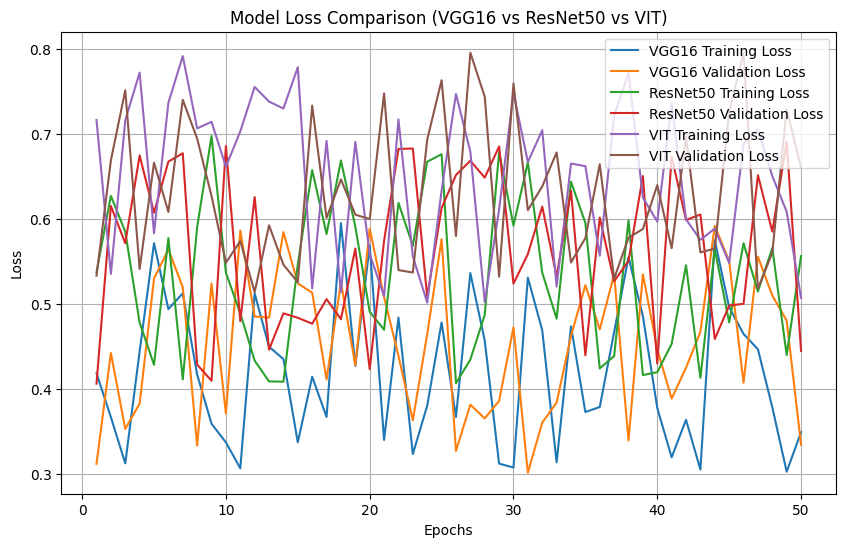

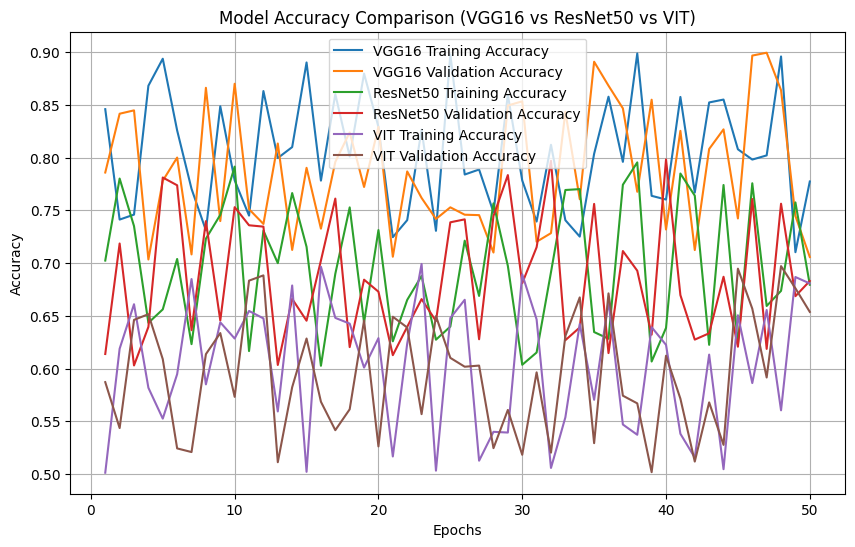

In [19]:
# Visualize Training and Validation Accuracies (VGG16 vs ResNet50 vs VIT)
plt.figure(figsize=(10, 6))
plt.plot(history_vgg16.history['accuracy'], label='VGG16 Training Accuracy')
plt.plot(history_vgg16.history['val_accuracy'], label='VGG16 Validation Accuracy')
plt.plot(history_resnet50.history['accuracy'], label='ResNet50 Training Accuracy')
plt.plot(history_resnet50.history['val_accuracy'], label='ResNet50 Validation Accuracy')
plt.plot(history_vit.history['accuracy'], label='VIT Training Accuracy')
plt.plot(history_vit.history['val_accuracy'], label='VIT Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison (VGG16 vs ResNet50 vs VIT)')
plt.legend()
plt.show()

# Visualize Training and Validation Losses (VGG16 vs ResNet50 vs VIT)
plt.figure(figsize=(10, 6))
plt.plot(history_vgg16.history['loss'], label='VGG16 Training Loss')
plt.plot(history_vgg16.history['val_loss'], label='VGG16 Validation Loss')
plt.plot(history_resnet50.history['loss'], label='ResNet50 Training Loss')
plt.plot(history_resnet50.history['val_loss'], label='ResNet50 Validation Loss')
plt.plot(history_vit.history['loss'], label='VIT Training Loss')
plt.plot(history_vit.history['val_loss'], label='VIT Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss Comparison (VGG16 vs ResNet50 vs VIT)')
plt.legend()
plt.show()


# **Model Deployment**

In [ ]:
saved_model_dir_vgg16 = 'saved_model_vgg16'
tf.keras.models.save_model(model_top_vgg16, saved_model_dir_vgg16)

saved_model_dir_resnet50 = 'saved_model_resnet50'
tf.keras.models.save_model(model_top_resnet50, saved_model_dir_resnet50)